# Logistic Regression

**Author:** Seda Radoykova, Science Executive (21/22), UCL DSS

**Date:** 11 Jan, 2022

***Proudly presented by the UCL Data Science Society***.

*The majority of the content of this workshop is based on this wonderful [RealPython tutorial](https://realpython.com/logistic-regression-python/), while this great [DataCamp tutorial](https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python) provided the basis of the data analysis.*

## Introduction
Welcome to this workshop about **Logistic Regression**. We will cover the [conceptual](#concepts) and [mathematical](#maths) foundations of the logistic regression classifier; take a look at a simple [example](#data) to learn how to [implement](#implement) logistic regression models in Python; finally, we will cover some [performance evaluation](#metrics) techniques and [conclude](#conclusion) by discussing the advantages and limitations of logistic regression. 


### Software prerequisites

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics # contains classification_report, confusion_matrix

<a id = "concepts"></a>
## Classification problems in ML

**Supervised** machine learning algorithms build models based on *labelled data sets*. The models use the labelled data in the learning process. Also known as **fitting**, this is the process of *adjusting the weights* or *parameters* based the data points. 
<br><br>
Problems in machine learning can therefore be broadly divided into **classification** and **regression**. We have already seen examples of applying regression to continuous prediction problems: *linear regression*. But as we know, data can broadly be defined as **categorical** or **continuous**. Can we use regression for categorical data? 
<br> <br>
The answer is yes, and this is the basis of **logistic regression**, the topic of this workshop. 
<br><br>
Confusingly, the predictions from logistic regression are used to *categorise/classify* data, *i.e.* predict which category an observation belongs to, based on its features. 
<br><br>
Some questions we might be interested in asnwering are, for example, "How likely is a person to suffer from a disease (**outcome**) given their age, sex, smoking status, *etc* (**varibles/features**)?" "How likely is this email to be spam?" "Will a student pass a test given some predictors of performance?"

It is important to keep in mind the distinction between **independent** and **dependent** variables:
<br>
* **Independent variable** (inputs or predictors) - as the name suggests, these should be independent of the outcome of interest (assume so!).
* **Dependent variables** (outputs or responses) - these depend on the independent variables.

Further to this, classification problems can be divided into:

- **Binary** or **binomial classification** - two possible outcomes (0 or 1, true or false, positive or negative, pass or fail, healthy or sick, spam or not spam).
- **Multiclass** or **multinomial classification** - three or more possible outputs (healthy, diease 1, disease 2). 
- **Ordinal** logistic regression - similar to multinomial, except the dependent variables have ordinal significance (for example, UK degree classification or restaurant ratings). 

We will only consider binary classification for the sake of simplicity. 

## Defining the problem, setting the scene

<a id = "maths"></a>
### Some background maths: the sigmoid function and a little bit of probability theory

The **sigmoid function** is also known as an S-shaped curve. It is defined as: <br>
$\sigma(x) = \frac{1}{1+e^{-x}}$ <br>
*Note (see graph below) how most values are very close to either 0 or 1.*

In [2]:
# implement a sigmoid function by hand
def sigmoid(x):
    a = []
    for item in x:
        a.append(1/(1+math.exp(-item)))
    return a

# evaluate the sigmoid at some x values
sigm = np.arange(-22, 22, 0.5)

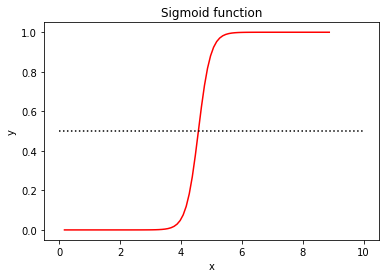

In [3]:
# plot the sigmoid
plt.plot(sigm*0.2+4.57, np.array(sigmoid(sigm)), color = "red") # manually implemented sigmoid
plt.plot([0,10], [0.5, 0.5], linestyle = "dotted", color = "black") 
plt.title("Sigmoid function")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

You might see the term **logit** function (logistic unit). 
The logit function is the inverse of the sigmoid function, $\sigma^{-1}$. 
Therefore: 
<br> $logit(p) = \sigma^{-1}(p) = \ln(\frac{p}{1-p})$ for $p \in (0;1)$ <br>
This is effectively the (natural) logarithm of the **odds ratio**. 
Hence, logit is also known as the log-odds. <br>
**Odds** is the probability that something happens divided by the probability it does not happen: <br>
$\frac{p}{1-p}$ <br>
*Note that you might see $log$ notation instead of $ln$, but log still implies $log(base=e)$.*

_This entire detour is to focus on our attention on how it is that we decide whether the predicted outcome will be 0 or 1 - it is all a matter of **probability**. (The **probability** of passing or failing, winning or losing, being healthy or diseased.)_

Let's actually start framing the problem by saying that we have a set of independent variables $ X = (x_1 , ... x_r )$, where $r$ is the number of predictors/inputs. We would like to predict the bonary outcome $y$. We have some known values of $x_i$ for which we have observed the corresponding $y_i$ and our data set consists of $n$ such pairs. 

Therefore, our goal is to fit the **logistic regression function** to our data, minimisiing the distance between the predicted (line) and the observed (dots) outcomes. Once we know the **parameters** of the logistic function, we can use it to predict unobserved values. 

Coming back to the sigmoid function:
<br> $\sigma(x) = \frac{1}{1+e^{-x}}$ <br>
In the place of $-x$, let's put the **linear predictor** function $f(x) = \beta_0 + \beta_1x_1 + ... + \beta_rx_r $. (The same linear predictor which we used for linear regression!) <br>
The sigmoid becomes the logistic regression function $p(x)$:
<br> $p(x) = \frac{1}{1+e^{-f(x)}}$ 
<br> $p(x) = \frac{1}{1+e^{-(\beta_0 + \beta_1x_1 + ... + \beta_rx_r)}}$ <br>
$\beta_0, \beta_1, ..., \beta_r$ are known as the **estimators**, **coefficients**, or **predicted weights**. 

Therefore, $p(x)$ can be treated as *the probability that the output for a given input is equal to* **1**, *i.e.* $P(y = 1)$ . Conversely, the probability that the output of a given input is equal to **0** is given by $1-p(x)$.

Therefore, **model fitting** or **training** in logistic regression is the process of determining the optimal values of the coefficients $\beta_0, \beta_1, ..., \beta_r$, such that the distance between the curve and the data points for each $y_i$ is as close as possible. There are many model fitting approaches, the most commonly used one being maximum-likelihood estimation (MLE). While it is beyond the scope of this tutorial, in the simplest terms we *optimise the likelihood function of the parameters given the data*. 


Notably, simply determining the weights is **not enough** to conclude our classification problem because we only have the *probability* that a given input is equal to 1 (or 0). We need a cutoff, a shortcut! <br> For example, for binary regression it makes sense for the algorithm to classify an input as 1 if $p>0.5$. Depending on the application, a different cutoff may be chosen. 

### Briefly comparing linear regression to logistic regression

Before we look at our data and the way we actually implement logicstic regression in Pyhton, let's dwell on the similarities and differences between linear and logistic regresion.

In [4]:
# let's generate some very arbitrary data
x = np.arange(10).reshape(-1, 1)
y = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])

Below, I will evaluate the linear and logistic regression function for this arbitrary dataset. (We will go through the details in a moment, just run these chunks...)

In [5]:
# a linear and a logistic regression model
## we'll see how that's done in more detail further on, this is just an illustration ## 
linr = LinearRegression().fit(x, y)
logr = LogisticRegression().fit(x, y)

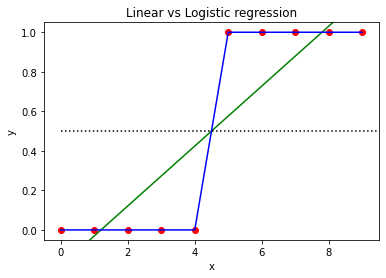

In [6]:
plt.scatter(x, y, color = "red") # scatterplot of data
plt.ylim([-0.05, 1.05])
plt.xlim([-0.5, 9.5])
plt.plot(x, linr.predict(x), color = "green") # linear regression
plt.plot(x, logr.predict(x), color = "blue") # logistic regression model
#plt.plot(sigm*0.2+4.57, np.array(sigmoid(sigm)), color = "black") # manually implemented sigmoid
plt.plot([0,10], [0.5, 0.5], linestyle = "dotted", color = "black") # our cutoff
plt.title("Linear vs Logistic regression")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Since the logistic regression (blue) looks a bit too exact, let's plot our smoother sigmoid curve from before.

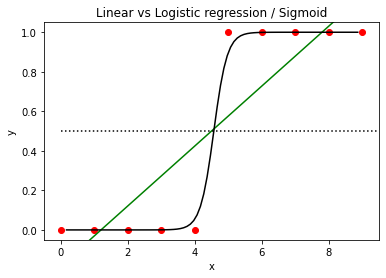

In [7]:
plt.scatter(x, y, color = "red") # scatterplot of data
plt.ylim([-0.05, 1.05])
plt.xlim([-0.5, 9.5])
plt.plot(x, linr.predict(x), color = "green") # linear regression
#plt.plot(x, logr.predict(x), color = "blue") # logistic regression model
plt.plot(sigm*0.2+4.57, np.array(sigmoid(sigm)), color = "black") # manually implemented sigmoid
plt.plot([0,10], [0.5, 0.5], linestyle = "dotted", color = "black") # our cutoff
plt.title("Linear vs Logistic regression / Sigmoid")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Note how the linear regression used here would still give *some* meaningful results. But the sigmoid is able to cover the entire dataset much more thoroughly and elegantly. <br>
Moreover, the dotted line at $y=0.5$ is that cutoff which I have been going on about all this time. Given our data (red), we find the sigmoid line, *i.e.* logistic regression function (black) with parameters such, that the black line is as close to the data as possible. <br> Then, when we evaluate a new observation, that is simply a dot somewhere on the black line. If the "dot" is in the upper part of the plane (above our cut-off), it is classified as a 1, otherwise, it is a 0. 

<a id = "data"></a>
## Introducing the dataset

We will use a dataset from [Kaggle](https://www.kaggle.com/uciml/pima-indians-diabetes-database) to *predict whether a person has diabetes based on several variables*. The data are a subset from a larger database from the National Institute of Diabetes and Digestive and Kidney Diseases. All the subjects are females, 21+ years old, and of Pima Indian heritage. 
> The datasets consists of several medical predictor variables and one target variable. Predictor variables includes the number of pregnancies the patient has had, their BMI, insulin level, age, and so on.

We have 8 predictors and one outcome. <br> 
- `pregnancies` = number of previous pregancies
- `glucose` = blood glucose levels from a glucose tolerance test
- `bp` = diastolic blood pressure values (mm Hg) 
- `skin_thickness` = triceps skin fold thickness (mm)
- `insulin` = levels of insulin 
- `bmi` = body mass index (BMI), $\frac{weight}{ height^2} = \frac{kg}{m^2}$
- `pedigree` = diabetes pedigree function
- `age` = age (years)
- `outcome` = health outcome (1 = diabetic, 0 = healthy)

You don't necessarily need to understand what relationship (if any??) these have with diabetes. The beauty of being a data scientist is that someone thought about the relationship between the variables at the stage of data collection - your task is to look at the models and evaluate them. 

In [8]:
# load dataset
diabetes = pd.read_csv("diabetes.csv")

# check for missing values
print("NaNs in data frame.\n") if diabetes.isnull().values.any() else print("No missing values.\n")

# print head
print(diabetes.head())

No missing values.

   pregnancies  glucose  bp  skin_thickness  insulin   bmi  pedigree  age  \
0            6      148  72              35        0  33.6     0.627   50   
1            1       85  66              29        0  26.6     0.351   31   
2            8      183  64               0        0  23.3     0.672   32   
3            1       89  66              23       94  28.1     0.167   21   
4            0      137  40              35      168  43.1     2.288   33   

   outcome  
0        1  
1        0  
2        1  
3        0  
4        1  


A brief note on input data format: note that every *observation* fits a *row* and every *predictor* has its own *column*. You might sometimes be given *frequency* tables - remember to recode these into this "long" format! 

Let's split our data into features and targets. Further, let's split the entire data set into training and testing subsets. We will use 75% of the data to train the model and 25% to test its performance.  

In [9]:
# split data into features/inputs and targets/outputs
feature_cols = ['pregnancies', 'insulin', 'bmi', 'age', 'glucose', 'bp', 'pedigree']
X = diabetes[feature_cols] # features
y = diabetes.outcome # target variable

In [10]:
# split data into training and validation datasets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

<a id = "implement"></a>
## Model training / fitting

In [11]:
# create model and train it
model = LogisticRegression()

We have just created an instance of a `LogisticRegression` object. <br>
`model.LogisticRegression` will take several parameters of which some immediately interesting mich be: 

- `fit_intercept` - Boolean, decides whether to calculate the intercept $\beta_0$ (when True, deafult) or consider it equal to zero (when False). 
- `intercept_scaling` - floating-point number, defines the scaling of the intercept $\beta_0$, (1.0 by default). 
- `class_weight` - dictionary, 'balanced', or `None` (default), defines the weights related to each class. When `None`, all classes have the weight one.
- `solver` - string, what solver to use for fitting the model. 'liblinear' by default; other options are 'newton-cg', 'lbfgs', 'sag', and 'saga'.
- `tol` - floating-point number, defines the tolerance for stopping the procedure (0.0001 by default).
- `n_jobs` - integer or `None` (default), defines the number of parallel processes to use. `None` usually means to use one core, while -1 means to use all available cores.

There are many other parameters which you are encouraged to explore in more complex applications. 

Having created a model, we now need to train it. This is done simply by supplying the training feature set: 

In [12]:
# fitting the model
model.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

`.fit()` requires the independent (`x`), and dependent (`y`) variables. It can also take observation-related weights. It fits the model and returns the model instance itself: <br>
`LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,     
                   intercept_scaling=1, l1_ratio=None, max_iter=100,             
                   multi_class='warn', n_jobs=None, penalty='l2',                
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,    
                   warm_start=False)                                           `

In [13]:
# an elecgant one line model creation and fitting can be done as follows: 
model = LogisticRegression().fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Taking advantage of attributes, we can retrieve the intercept, $\beta_0$, and the slopes, $\beta_1, ..., \beta_r$, as follows: 

In [14]:
print("The intercept is %.3f" % model.intercept_)
print("The model coefficients are:")
for i,j in zip(feature_cols, model.coef_.reshape(-1,1)):
    print("\t %s %.4f" % (i,j))

The intercept is -8.050
The model coefficients are:
	 pregnancies 0.0897
	 insulin -0.0005
	 bmi 0.0942
	 age 0.0230
	 glucose 0.0306
	 bp -0.0150
	 pedigree 1.0254


Note that the intercept is in a one-dimensional array, whereas the coefficients (slopes) are in a two-dimensional array. 

In the introduction we called the logit function a "log-odds ratio". This means that if we convert from the logarithmic form back to the exponential form, we will get the **odds ratios** for each predictor. These odds ratios are also known as **effect sizes**. Effect sizes are really important, as they give us an indication of the magnitude of the impact every predictor has on the outcome of interest.

In [15]:
print("The effect sizes are:")
for i,j in zip(feature_cols, np.exp(model.coef_.reshape(-1,1))):
    print("\t %s %.4f" % (i,j))

The effect sizes are:
	 pregnancies 1.0938
	 insulin 0.9995
	 bmi 1.0988
	 age 1.0233
	 glucose 1.0311
	 bp 0.9851
	 pedigree 2.7883


It is important that the effects of each odds ratio are **multiplicative**. Therefore, the closer an effect size is to 1, the more negligible its impacts are on the outcome. Odds greater than 1 indicate an increase in the likelihood of an outcome and *vice versa* for outcomes less than 1. 
<br><br>
Examining the table above, we can conclude that insulin levels are not a great predictor of diabetes. 
<br><br>
Age, glucose levels, and blood pressure also have quite small effect sizes (up to 1 +/- 0.03). 
<br><br>
Previous pregnancies and BMI both seem to have a protective effect against diabetes. 
<br><br>
Perhaps not surprisingly, the greatest predictor of diabetes is genealogical - in other words, genetic. It increases the odds of having diabetes almost three-fold! 

<a id = "metrics"></a>
## Evaluating model performance

Once we have fit our model, we would be interested in evaluating how well the classifier is performing. While in a good mdel, many of the predictions will be accurate, still,, inevitably, there will be errors. Sometimes the model will misplace healthy individuals with diabetic ones (false-positives) or *vice versa*, diabetic individuals will be classified as healthy (false-negatives). Therefore, there is a wealth of measures we can use to understand and evaluate the performance of our model. 

**Accuracy** is the simplest and most intuitive measure of performance. It is given by the ratio between the number of *correct* predictions and the *total* number of predictions. The *correct* predictions are predicting 1 when the truth is also 1 (true positive) and predicting 0 when the truth is 0 (true negative). After all, what good is a test which predicts at random and gives lots of incorrect predictions?

$ accuracy = \frac{TP + TN}{TP + TN + FP + FN} $

**Precision** is about the consistency of the results we obtain. How much noise is there in the performance of the model: *What proportion of positive predictions is actually correct?* That's why precision is given by the ratio of the true positives and the sum of the true positives and false positives (noise, imprecision). So when our model predicts that someone is diabetic, precision will give us the probability/ratio/percentage that this prediction is correct. 

$ precision = \frac{TP}{TP + FP} $

Note that a model can be accurate but imprecise (*i.e.* it is *capable* of giving right predictions (unbiased), it's just not consistent) and inaccurate but precise (*i.e.* it is *biased* but consistent). Also note how these extremes are both not very useful. 

**Sensitivity (recall,  true positive rate)** is the flip-side of precision. It indicates how many of the *total* positive cases the model is able to identify (i.e. how many cases could we miss if we assumed the model was perfect?) 

$ sensitivity = \frac{TP}{(TP + FN)} $

To give an example, if a spam filter is 80% precise and 60% sensitive, it will give an accurate spam classification 8 out of 10 times, but it will only identify 6 out of 10 spam emails. This is probably one of the most important trade-offs!  

**Specificity (true negative rate)** is the opposite of sensitivity. If sensitivity is about being able to identify as many of the true positives as possible, specificity is about being able to reject as many of the true negatives as possible. For example, if a medical test is 95% specific, out of 100 *healthy* individuals tested, 95% will test negative. 5 will test positive despite not having a disease!  

$ specificity = \frac{TN}{(TN + FP)} $

**Confusion matrix** - a 2x2 matrix with *diagonal entries representing accurate predictions*, and *non-diagonal entries being inaccurate predictions*. It is a very neat way of summarising true and false predictions.
- True negatives (TN): correctly predicted negatives (0)
- True positives(TP): correctly predicted positives (1)
- False negatives (FN): incorrectly predicted negatives (0)
- False positives (FP): incorrectly predicted positives (1)


**$F_1$ score** is another measure of a test or model's accuracy. It is the **harmonic mean** of precision and recall. If we come back to the spam filter example, the perfect spam filter would always *accurately filter out* a given email, and it would *not miss any spam emails*. In this case, it would have an F-score of 1.0. 

$ F_1\ score= 2* \frac{precision*recall}{precision+recall}$

It is important to keep in mind that none of these metrics is fool-proof or comprehensive. There are many more performance evaluation measures out there. The choice of metrics will critically depend on the **goal and application** of your model. 

But how do we actually get these metrics in Python? 
<br><br>
Let's first make some predictions. `.predict_proba()` returns a matrix of probailities that the predicted output is equal to 0 or 1. <br>
The first column is the probability of the predicted output being 0, that is 1 - 𝑝(𝑥). <br>
The second column is the probability that the output is 1, or 𝑝(𝑥).

In [16]:
model.predict_proba(X_train)[0:5] # let's just look at the output of a few

array([[0.91895474, 0.08104526],
       [0.79136004, 0.20863996],
       [0.89835642, 0.10164358],
       [0.18373163, 0.81626837],
       [0.25492803, 0.74507197]])

Remember that the logistic regression only returns *a probability* that an individual is diseased or not, not a definitive answe. The answer comes from our "cut-off": $P=0.5$ in this case. Hence, to obtain actual predictions, we would use `.predict()`, which returns the predicted outputs. 

In [17]:
y_pred = model.predict(X_test)
y_pred[0:5]

array([1, 0, 0, 1, 0], dtype=int64)

In [18]:
# metrics
print("Accuracy for test set is {}.".format(round(metrics.accuracy_score(y_test, y_pred), 4)*100))
print("Precision for test set is {}.".format(round(metrics.precision_score(y_test, y_pred), 4)*100))
print("Recall for test set is {}.".format(round(metrics.recall_score(y_test, y_pred), 4)*100))

Accuracy for test set is 80.73.
Precision for test set is 74.51.
Recall for test set is 61.29.


We can also get a classification report which includes precision, recall, and the f1-score. 

In [19]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86       130
           1       0.75      0.61      0.67        62

    accuracy                           0.81       192
   macro avg       0.79      0.76      0.77       192
weighted avg       0.80      0.81      0.80       192



We could obtain a confusion matrix using one line of code too. 

In [20]:
conf_mat = metrics.confusion_matrix(y_test, y_pred)
print(conf_mat)

[[117  13]
 [ 24  38]]


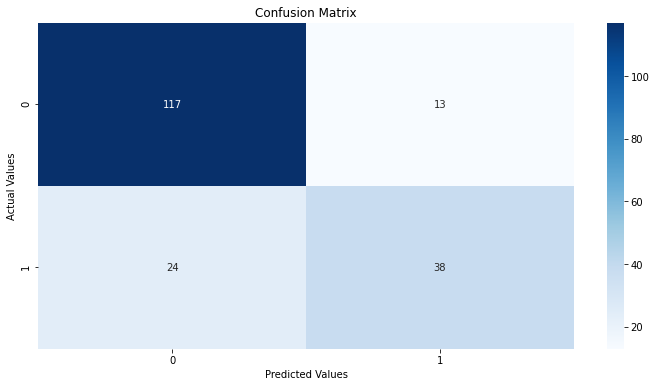

In [21]:
# plotting the confusion matrix
plt.figure(figsize=(12,6))
plt.title("Confusion Matrix")
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.ylabel("Actual Values")
plt.xlabel("Predicted Values")
plt.savefig('confusion_matrix.png')

### ROC curve

**Receiver Operating Characteristic (ROC)** curve is anoher characteristic plot which you will see everywhere in machine learning contexts. It plots the true positive rate against the false positive rate, showing the tradeoff between *sensitivity* and *specificity*. The **area under the curve (AUC)** showws how close the classifier is to ideal performance. Therefore, the "best" ROC curve of a model with 100% specificity and sensitivity would look like an upside-down L, and the AOC would be 1. 

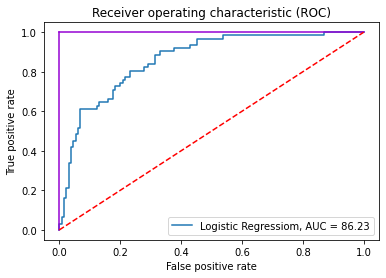

In [22]:
# ROC curve
y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr, tpr, label="Logistic Regressiom, AUC = " + str(round(auc*100,2)))
plt.plot([0,0], [0,1], color = "darkviolet") # ideal curve
plt.plot([0,1], [1,1], color = "darkviolet") # ideal curve 
plt.plot([0, 1], [0, 1],'r--') # random classification
plt.legend(loc=4)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("Receiver operating characteristic (ROC)")
plt.show()

In the visualisation above, the ROC curve is shown in blue, while the "ideal" ROC curve is in violet. The red line shows a completely random classifies. We can see that our classifier is closer to ideal behaviour than to completely random behaviour. 

<a id = "conclusion"></a>
## Concluding remarks

We have leared how to implement a simple case of the logistic regression. As we saw, logistic regression is a relatively intuitive, efficient, and elegant classification technique which provides us with a probability for a given outcome given some observation. This makes it a very popular classifier. There are several advantages to using logistic regression. Many would say that the main one is that it does not require high computational power. In addition, it is easy to implement, even from scratch, and the interpretation is fairly straightforward. 
<br><br>
Despite the great popularity enjoyed by logistic regression, it's important to keep in mind that it suffers several shortcomings. One of the main limitations to keep in mind is that it *cannot handle highly complex models* with many predictor variables. In these cases, **model selection** must be carried out. Unfortunately, we do not have time to go into this in the scope of today's workshop. Deciding which variables to include in the model can be non-trivial. This is the bit where understanding the relationships between the different variables and the source of the data can be important.
<br><br>
In addition, to give meaningful predictions, logistic regression models need to be trained on large samples. Logistic regression models are also prone to **overfitting**: learning the data "too well" (learning the noise in the data). This will be covered in our next workshop, together with **regularisation**, a helpful solution. They *cannot solve non-linear problems*; hence, they require non-linear data to be *transformed*. If the dependency between the independent and the dependent variable is *weak*, the classifier will not perform well. Finally, if the independent variables are not in fact independent, the model performance will suffer from **collinearity**. Again, while we cannot cover collinearity within the scope of this workshop, it is something worth lookning into. 
<br><br>
Still, there is a wealth of other classification techniques which could be used as alternatives. We will cover these in future workshops. 
- Naive Bayes classifiers
- Support vector machines (SVM)
- Decision trees
- Random forests
- Neural networks

# Further resources and links consulted

- Here's an example of a multiple regression model: [classifying images of digits](https://towardsdatascience.com/logistic-regression-using-python-sklearn-numpy-mnist-handwriting-recognition-matplotlib-a6b31e2b166a). 
- A very detailed [RealPython tutorial](https://realpython.com/logistic-regression-python/), most of this workshop is based on the information provided.
- A wonderful [DataCamp tutorial](https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python) providing the basis of the data analysis. 

And further reading wth more examples for those interested.
- https://asperbrothers.com/blog/logistic-regression-in-python/  
- https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8  
- https://towardsdatascience.com/logistic-regression-using-python-sklearn-numpy-mnist-handwriting-recognition-matplotlib-a6b31e2b166a
- https://www.nature.com/articles/nmeth.3904
- https://www.ibm.com/cloud/learn/supervised-learning